In [126]:
!pip install graphviz

In [158]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [159]:
# Values of Different parametes
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 30000
MAX_SENTENCE_LENGTH = 100
MAX_NUM_WORDS = 10000
EMBEDDING_SIZE = 200

# Data Preprocessing 

In [248]:
input_sentences = []
output_sentences = []
output_sentences_input = []

counter = 0
for line in open(r"C:\Users\aplus\NMT\spa.txt", encoding= "utf-8"):
    counter += 1
    if counter > NUM_SENTENCES:
        break
    if "\t" not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]    
    output_part = line.rstrip().split('\t')[1]

#adding eos and sos in the output part
    output_sentence = output_part + '<eos>'
    output_sentence_input = '<sos>' + output_part

#appending into respective lists
    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_input.append(output_sentence_input)

In [249]:
#printing the lists
print("No. of input are:", len(input_sentences))
print("No. of ouput are:", len(output_sentences))
print("No. of output-input are:", len(output_sentences_input))

No. of input are: 30000
No. of ouput are: 30000
No. of output-input are: 30000


### Printing Sentences in English and their Spanish Translations

In [250]:
print("English Sentence is:", input_sentences[250])
print("Spanish Translation is:", output_sentences[250])

print("English Sentence is:", input_sentences[2654])
print("Spanish Translation is:", output_sentences[2654])

print("English Sentence is:", input_sentences[10000])
print("Spanish Translation is:", output_sentences[10000])

English Sentence is: Push it.
Spanish Translation is: Empújadlo.<eos>
English Sentence is: Stop moving.
Spanish Translation is: Deja de moverte.<eos>
English Sentence is: I want to leave.
Spanish Translation is: Me quiero ir.<eos>


## Data Visualization 

<function matplotlib.pyplot.show(close=None, block=None)>

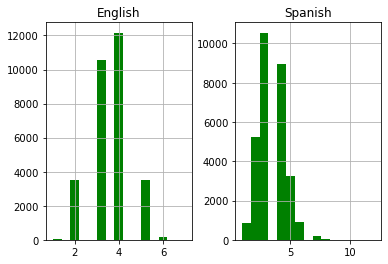

In [251]:
# creating lists for storing lengths of english and spanish
len_eng = []
len_spa = []

# appending sentences lengths
for i in input_sentences:
    len_eng.append(len(i.split()))
    
for i in output_sentences:
    len_spa.append(len(i.split()))
    
len_df = pd.DataFrame({'English':len_eng, 'Spanish':len_spa})
len_df.hist(bins = 15, color = 'green')
plt.show


## Tokenization


In [252]:
# tokenize the english(input) sentences
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
max_len_input = max(len(sent) for sent in input_integer_seq)

#printing length of max sentence and number of unique words
print(input_integer_seq)
print('No. of Unique Words are:', len(word2idx_inputs))
print('Max of length of sentence is:', max_len_input)

[[24], [24], [24], [24], [557], [287], [287], [287], [287], [287], [56], [1285], [1445], [450], [450], [450], [61], [61], [61], [451], [788], [788], [788], [105], [74], [74], [74], [115], [115], [115], [115], [481], [24, 36], [24, 36], [1286], [241], [241], [241], [1, 1153], [1, 1153], [1, 1153], [1, 1153], [1, 232], [1, 232], [1, 80], [1, 261], [1077, 58], [754], [611], [611], [611], [611], [611], [611], [611], [789], [386], [1078], [1078], [1078], [1078], [1078], [50, 39], [24, 45], [24, 45], [24, 45], [24, 45], [24, 45], [24, 45], [24, 45], [24, 45], [62, 6], [62, 6], [62, 6], [10, 232], [10, 232], [3169, 28], [790, 11], [1, 415], [1, 461], [1, 1664], [1, 1664], [1, 1664], [1, 1664], [1, 35], [1, 35], [1, 155], [1, 482], [1, 103], [1, 591], [1, 380], [1, 380], [1, 380], [1, 638], [1, 1446], [1, 1446], [1, 99], [8, 1973], [8, 39], [288], [288], [288], [58, 204], [58, 204], [58, 204], [58, 204], [58, 204], [58, 204], [58, 204], [58, 204], [58, 204], [58, 204], [149], [149], [395], [39

In [253]:
word2idx_inputs.items()

dict_items([('i', 1), ('tom', 2), ('you', 3), ('is', 4), ('a', 5), ('it', 6), ('the', 7), ("i'm", 8), ('to', 9), ('he', 10), ('me', 11), ('this', 12), ('do', 13), ('my', 14), ('are', 15), ('was', 16), ('we', 17), ('that', 18), ("it's", 19), ("don't", 20), ('have', 21), ('your', 22), ('can', 23), ('go', 24), ('like', 25), ('not', 26), ("you're", 27), ('in', 28), ('she', 29), ('they', 30), ('here', 31), ('did', 32), ('what', 33), ('be', 34), ('know', 35), ('on', 36), ('want', 37), ("i'll", 38), ('up', 39), ('mary', 40), ('come', 41), ('him', 42), ("can't", 43), ('very', 44), ('now', 45), ("we're", 46), ('need', 47), ('how', 48), ("that's", 49), ('get', 50), ('has', 51), ('for', 52), ('love', 53), ('at', 54), ('please', 55), ('who', 56), ('good', 57), ('no', 58), ('see', 59), ('just', 60), ('help', 61), ('got', 62), ("let's", 63), ('out', 64), ('of', 65), ('there', 66), ('his', 67), ('all', 68), ('her', 69), ('am', 70), ('will', 71), ('an', 72), ('why', 73), ('stop', 74), ("tom's", 75), (

In [300]:
# tokenizing the spanish(Output) sentnces
output_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters = '')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_input)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_input)

word2idx_outputs = output_tokenizer.word_index
max_len_out = max(len(sent) for sent in output_integer_seq)
max_num_words_output = len(word2idx_outputs) + 1

#printing length of max sentence and number of unique words
print(output_integer_seq)
print('No. of Unique Words are:', len(word2idx_outputs))
print('Max of length of sentence is:', max_len_out)
print(max_num_words_output)

[[7771], [4574], [3263], [6051], [6052], [], [], [], [], [], [], [2043], [], [6053], [], [6054], [], [7772], [7772], [7773], [], [7774], [7775], [7776], [], [], [], [7777], [], [], [3264], [6055], [3921], [7778], [6052], [7779, 6056], [6056], [7780, 927], [9], [9], [9], [9], [], [6057], [13, 6058], [6059, 4575], [], [7781, 35, 7782], [6053], [6054], [], [], [], [], [], [6060], [], [6061], [], [], [], [], [7783], [162, 121, 369], [3265, 121, 369], [1032, 121, 369], [4576, 121, 369], [162, 902], [3265, 902], [1032, 902], [4576, 902], [2889, 7784], [406, 7785], [7786], [22, 3266], [3266], [6062, 1090], [], [9, 7787], [9, 7788], [], [9], [], [9], [31, 13, 903], [903], [7789], [3922], [7790], [7791], [7792], [7793], [13, 3923], [7794], [7795], [7796], [20, 1091], [39], [20, 4577], [2044], [7797], [7798], [281, 50, 7799], [6, 1515, 3267], [3924, 1515], [], [3924, 660], [3924, 56, 7800], [7801], [], [], [7801, 17], [987, 4578], [1516, 1899], [6063], [6063], [1517], [4579], [2, 12, 1737, 105, 

In [302]:
print(output_tokenizer.word_index)

{'es': 1, 'a': 2, 'no': 3, 'un': 4, 'tom': 5, 'de': 6, 'la': 7, '<sos>tom': 8, 'me': 9, 'el': 10, 'está': 11, 'que': 12, 'lo': 13, '<sos>no': 14, 'se': 15, 'una': 16, 'en': 17, 'mi': 18, '<sos>me': 19, 'estoy': 20, 'te': 21, 'él': 22, 'los': 23, '<sos>él': 24, 'por': 25, 'gusta': 26, 'le': 27, 'muy': 28, 'tu': 29, 'las': 30, 'yo': 31, 'tom.<eos>': 32, 'tom.': 33, 'soy': 34, 'con': 35, '<sos>yo': 36, 'estaba': 37, 'tiene': 38, 'tengo': 39, 'puedo': 40, '<sos>es': 41, 'son': 42, 'qué': 43, '<sos>estoy': 44, 'ella': 45, 'su': 46, '<sos>ella': 47, 'están': 48, 'fue': 49, 'puede': 50, '¿qué': 51, 'tan': 52, 'al': 53, '<sos>¿qué': 54, 'he': 55, 'eso': 56, 'ha': 57, 'más': 58, 'quiero': 59, 'nos': 60, '<sos>soy': 61, '<sos>lo': 62, 'era': 63, '<sos>el': 64, 'este': 65, 'esto': 66, '<sos>la': 67, 'estás': 68, 'eres': 69, '<sos>tengo': 70, '¿quién': 71, '<sos>¿quién': 72, '<sos>eso': 73, 'sé': 74, '<sos>esto': 75, 'para': 76, 'estamos': 77, 'esta': 78, 'aquí.<eos>': 79, 'aquí.': 80, '<sos>te': 

## Word Embeddings and Padding

In [167]:
# padding input integer sequence
encoder_input_seq = pad_sequences(input_integer_seq, maxlen = max_len_input, padding = 'pre')
print('Shape of encoder_input_seq:', encoder_input_seq.shape)
print('encoder_input_Seq[10000]:', encoder_input_seq[10000])

print(word2idx_inputs["want"])
print(word2idx_inputs["to"])
print(word2idx_inputs["leave"])

Shape of encoder_input_seq: (30000, 7)
encoder_input_Seq[10000]: [  0   0   0   1  37   9 107]
37
9
107


In [168]:
# padding output-input integer sequence
decoder_input_seq = pad_sequences(output_input_integer_seq, maxlen = max_len_out, padding = 'post')
print("decoder_input_seq_shape:", decoder_input_seq.shape)
print("decoder_input_seq[10000]:", decoder_input_seq[10000])

print(word2idx_outputs['quiero'])

decoder_input_seq_shape: (30000, 11)
decoder_input_seq[10000]: [ 19  59 216   0   0   0   0   0   0   0   0]
59


In [169]:
# padding output integer sequence
decoder_output_seq = pad_sequences(output_integer_seq, maxlen = max_len_out, padding = 'post')
print("decoder_output_seq_shape:", decoder_output_seq.shape)

decoder_output_seq_shape: (30000, 11)


In [170]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove = open(r"E:\GloVe\glove.twitter.27B.200d.txt", encoding="utf-8")

for line in glove:
    split = line.split()
    word = split[0]
    vector_dimensions = asarray(split[1:], dtype = 'float32')
    embeddings_dictionary[word] = vector_dimensions
glove.close()



In [179]:
embeddings_dictionary['want']

array([ 3.1705e-01,  5.1477e-01, -2.6564e-01,  2.4678e-01, -5.7847e-01,
        1.6954e-02,  1.1577e+00, -3.2305e-03,  3.4475e-01, -1.3488e-01,
        1.0422e-01,  6.8276e-03, -8.0510e-01, -3.6663e-01, -4.0757e-01,
       -5.4079e-02, -4.2320e-01, -3.3805e-01, -6.0864e-01,  2.1169e-01,
       -3.1968e-01, -2.2384e-01, -5.0787e-02,  3.1696e-01,  3.3161e-01,
        1.2943e+00,  5.4816e-01,  8.9259e-02, -1.4300e-01, -5.0095e-01,
       -1.8067e-01,  4.3625e-02, -3.1720e-02,  1.2342e-01, -5.6242e-01,
       -3.0011e-01,  5.8345e-01,  3.2001e-01,  4.4124e-02, -2.5603e-02,
        5.1260e-02, -9.6835e-02, -3.2223e-01, -1.6501e-01,  4.4382e-01,
       -7.0233e-02,  3.6004e-01,  8.3768e-02, -1.5218e-02,  3.4368e-01,
        6.6408e-02,  2.2337e-01, -3.2754e-01, -1.4426e-01, -4.6219e-01,
       -2.9183e-01,  1.4573e-02, -8.2652e-03,  3.9635e-01,  1.2156e-01,
       -4.0001e-01, -2.9667e-01,  1.6955e-01,  3.5634e-01,  1.7074e-01,
        1.3912e-01, -1.6545e-01,  1.0847e-01, -2.9364e-01, -1.46

In [180]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
print(embedding_matrix)
print('Shape of embedding Matrix is:',embedding_matrix.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of embedding Matrix is: (4883, 200)


In [181]:
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_vector

array([ 0.38028  ,  0.015056 ,  0.21927  ,  0.31699  ,  0.10644  ,
        0.81856  ,  0.64055  ,  0.17552  , -0.30384  , -0.20938  ,
       -0.060946 , -0.15255  , -0.38193  , -0.84465  , -0.084863 ,
        0.39061  , -0.48785  ,  0.24252  , -0.39106  ,  0.34886  ,
       -0.052259 , -0.18458  ,  0.17645  , -0.36091  ,  0.0094872,
        1.6089   , -0.010014 ,  0.22899  ,  0.50213  ,  0.464    ,
       -0.34638  , -0.72668  ,  0.33817  ,  0.41977  ,  0.47925  ,
       -0.18179  ,  0.17899  ,  0.1443   , -0.49867  , -0.4502   ,
        1.1413   , -0.049927 ,  0.29781  , -0.034017 ,  0.071995 ,
        0.20788  ,  0.097162 ,  0.25462  ,  0.036784 ,  0.8169   ,
       -0.17254  , -0.54379  , -0.079279 , -0.52189  ,  0.47024  ,
        0.19375  , -0.17775  , -0.65856  ,  0.084587 ,  0.058026 ,
       -0.11277  ,  0.20538  ,  0.023001 , -0.26316  ,  0.3682   ,
        0.013052 , -0.40565  , -0.82248  , -0.12668  , -0.9673   ,
        0.17712  ,  0.19132  ,  0.31902  ,  0.4105   ,  0.4310

In [182]:
# creating embedding layer
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights = [embedding_matrix], input_length = max_len_input)

# onehot representation
decoder_one_hot = np.zeros((len(input_sentences), max_len_out, max_num_words_output), dtype = 'uint8')
decoder_one_hot.shape


(30000, 11, 25413)

In [198]:
for i, d in enumerate(decoder_output_seq):
    for t, word in enumerate(d):
        decoder_one_hot[i, t, word] = 1
decoder_one_hot

array([[[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 

## CREATING THE MODEL

In [184]:
# Encoder LSTM Model
encoder_inputs = Input(shape = (max_len_input,))
a = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state = True)
o_e,h_e,c_e = encoder(a)
encoder_states = [h_e,c_e]


In [319]:
a

<KerasTensor: shape=(None, 7, 200) dtype=float32 (created by layer 'embedding_14')>

In [185]:
# Decoder LSTM Model
decoder_inputs = Input(shape = (max_len_out,))
decoder_embedding = Embedding(max_num_words_output, LSTM_NODES)
b = decoder_embedding(decoder_inputs)
decoder = LSTM(LSTM_NODES, return_state = True, return_sequences = True)
o_d,h_d,c_d =decoder(b, initial_state = encoder_states) 

In [178]:
# Dense Model 

In [189]:
decoder_dense = Dense(25413, activation = 'sigmoid')
decoder_outputs = decoder_dense(o_d)

## Compiling The Model

In [199]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 11)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 7, 200)       976600      ['input_10[0][0]']               
                                                                                                  
 embedding_15 (Embedding)       (None, 11, 256)      6505728     ['input_11[0][0]']               
                                                                                           

In [200]:
#from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#fitting the model
history = model.fit([encoder_input_seq, decoder_input_seq], decoder_one_hot,batch_size = BATCH_SIZE, epochs = 5,validation_split = 0.2)

Epoch 1/5
375/375 [==============================] - 140s 364ms/step - loss: 1.7598 - accuracy: 0.7580 - val_loss: 1.6298 - val_accuracy: 0.7715
Epoch 2/5
375/375 [==============================] - 134s 357ms/step - loss: 1.1211 - accuracy: 0.8520 - val_loss: 1.1951 - val_accuracy: 0.8480
Epoch 3/5
375/375 [==============================] - 133s 354ms/step - loss: 0.8687 - accuracy: 0.8883 - val_loss: 1.0162 - val_accuracy: 0.8736
Epoch 4/5
375/375 [==============================] - 133s 356ms/step - loss: 0.7270 - accuracy: 0.9078 - val_loss: 0.8907 - val_accuracy: 0.8935
Epoch 5/5
375/375 [==============================] - 132s 353ms/step - loss: 0.6245 - accuracy: 0.9218 - val_loss: 0.8190 - val_accuracy: 0.9053


In [201]:
model.save('eng_spa.h5')

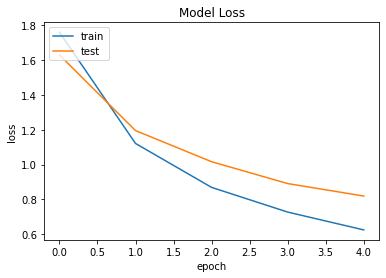

In [202]:

import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

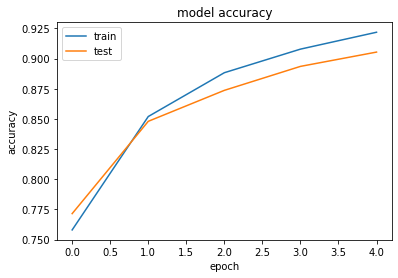

In [203]:
plt.title('model accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [205]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('eng_spa.h5')

In [206]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


In [280]:
decoder_outputs, h, c = decoder(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
decoder_states

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_9')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_9')>]